# Gridworld Maze Navigation


## High-Level Overview
We train a reinforcement-learning agent in a 2D grid with random obstacles. The agent starts in one cell and aims to reach a goal cell, receiving a small negative reward for each step (to encourage faster completion) and a positive reward upon reaching the goal. Over many episodes, the agent refines its strategy for which action to take from each cell.

## What the Red Arrows Represent
During training, each cell’s “best-known” action is determined by looking at the **Q-values** for that cell. The Q-value measures the expected cumulative reward for taking a certain action in that cell and then following the current policy. The red arrows indicate the agent’s current guess of the best action (the action with the highest Q-value) for every visited cell. As training proceeds, the arrows may change in response to updated Q-values, reflecting the agent’s improved knowledge of the environment.

## Algorithmic Details
1. **Environment**: We define a grid of size 15×15. Some cells are marked as blocked (obstacles), and the agent cannot move into them. The agent starts in a random free cell and must reach another random free cell (the goal).
2. **Actions**: At each time step, the agent can move **up**, **right**, **down**, or **left**.
3. **Reward**:
   - **+1** upon reaching the goal.
   - **-0.01** for every step, to penalize moving indefinitely.
4. **Q-learning**:
   - **Q-table**: A 3D array storing Q-values for each state (row, column) and each action (4 possible moves).
   - **Epsilon-greedy**: With probability \( \epsilon \), pick a random action; otherwise, pick the action with the highest Q-value.
   - **Update Rule**:  
     $$Q_{\text{new}}(s,a) \leftarrow Q_{\text{old}}(s,a) \;+\; \alpha \bigl(r + \gamma \max_{a'} Q(s',a') - Q_{\text{old}}(s,a)\bigr)$$
     where \(r\) is the immediate reward, \(\alpha\) is the learning rate, and \(\gamma\) is the discount factor.
5. **Animation**:
   - We train step-by-step and capture frames of:
     1. The agent’s position in the grid.
     2. The red arrows showing the highest Q-value action in each visited cell so far.
   - By replaying these frames, we see how the agent’s knowledge (best actions) evolves and how it explores/learns to reach the goal.


In [4]:
# save animation

<IPython.core.display.Javascript object>


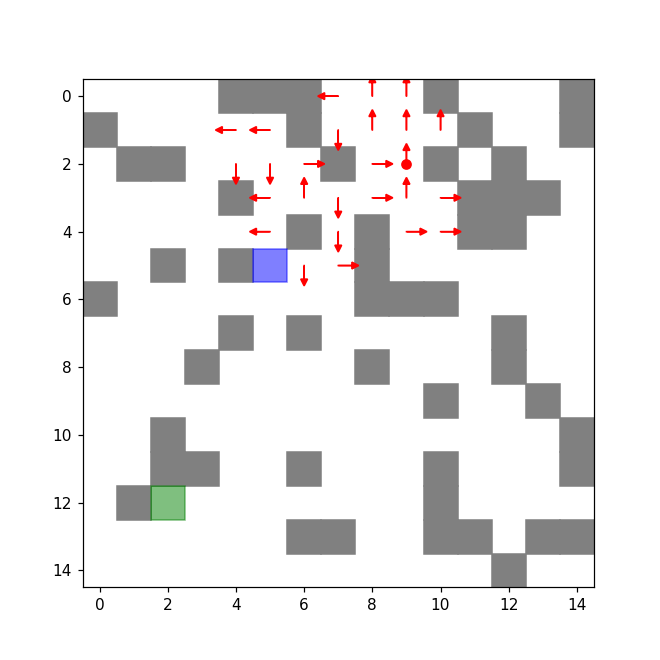

/tmp/ipykernel_6184/3909672914.py:162: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(agent_pos[1], agent_pos[0])


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.animation as animation

%matplotlib notebook

# ---------------------
# Environment Setup
# ---------------------
class GridWorld:
    '''
    A larger gridworld environment with random obstacles.
    The agent moves in a 2D grid to reach a randomly chosen goal.
    '''
    def __init__(self, grid_size=15, obstacle_prob=0.2, seed=42):
        np.random.seed(seed)
        self.grid_size = grid_size
        self.blocked_cells = []
        
        # Randomly generate blocked cells
        for r in range(grid_size):
            for c in range(grid_size):
                if np.random.rand() < obstacle_prob:
                    self.blocked_cells.append((r, c))
        
        # Ensure valid start/goal
        self.start = self._get_random_free_cell()
        self.goal = self._get_random_free_cell()
        while self.goal == self.start:
            self.goal = self._get_random_free_cell()
        
        self.reset()
    
    def _get_random_free_cell(self):
        ''' Return a random free cell. '''
        while True:
            r = np.random.randint(0, self.grid_size)
            c = np.random.randint(0, self.grid_size)
            if (r, c) not in self.blocked_cells:
                return (r, c)
    
    def reset(self):
        ''' Reset agent to start; return the start state. '''
        self.agent_pos = self.start
        return self.agent_pos
    
    def step(self, action):
        ''' 0=up,1=right,2=down,3=left. Return (next_state, reward, done). '''
        r, c = self.agent_pos
        
        if action == 0 and r > 0:
            r -= 1
        elif action == 1 and c < self.grid_size - 1:
            c += 1
        elif action == 2 and r < self.grid_size - 1:
            r += 1
        elif action == 3 and c > 0:
            c -= 1

        # Check blocked
        if (r, c) in self.blocked_cells:
            r, c = self.agent_pos
        
        self.agent_pos = (r, c)
        
        if self.agent_pos == self.goal:
            return (r, c), 1.0, True
        return (r, c), -0.01, False

# ---------------------
# Q-Learning with Frame Capture
# ---------------------
def train_and_capture_frames(env, episodes=50, alpha=0.5, gamma=0.9, epsilon=0.1):
    '''
    Train the agent step by step, capturing frames for animation.
    Returns:
      Q: final Q-table
      frames: list of (agent_pos, visited_states, Q_snapshot) for each step
    '''
    Q = np.zeros((env.grid_size, env.grid_size, 4))
    actions = [0, 1, 2, 3]
    
    frames = []
    visited_states = set()

    for _ in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            visited_states.add(state)
            
            # Epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.choice(actions)
            else:
                action = np.argmax(Q[state[0], state[1], :])
            
            next_state, reward, done = env.step(action)
            
            # Update Q
            old_val = Q[state[0], state[1], action]
            next_max = np.max(Q[next_state[0], next_state[1], :])
            Q[state[0], state[1], action] = old_val + alpha * (reward + gamma * next_max - old_val)
            
            # Capture frame
            frames.append((env.agent_pos, visited_states.copy(), np.copy(Q)))
            
            state = next_state
    return Q, frames

# ---------------------
# Animation
# ---------------------
def animate_training(env, frames):
    '''
    Create an animation from the frames.
      Each frame shows environment, agent, and best-known actions for visited cells.
    Returns:
      ani: FuncAnimation object
    '''
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    plt.gca().invert_yaxis()
    plt.grid(False)
    
    # Draw environment
    for (r, c) in env.blocked_cells:
        ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, color='gray'))
    ax.add_patch(plt.Rectangle((env.goal[1] - 0.5, env.goal[0] - 0.5), 
                               1, 1, color='green', alpha=0.5))
    ax.add_patch(plt.Rectangle((env.start[1] - 0.5, env.start[0] - 0.5), 
                               1, 1, color='blue', alpha=0.5))

    agent_dot, = ax.plot([], [], 'ro', markersize=6)
    arrow_patches = []
    
    def draw_arrow(r, c, action):
        # 0=up,1=right,2=down,3=left
        arrow_dict = {
            0: (c, r, 0, -0.4),
            1: (c, r, 0.4, 0),
            2: (c, r, 0, 0.4),
            3: (c, r, -0.4, 0),
        }
        x, y, dx, dy = arrow_dict[action]
        return ax.arrow(x, y, dx, dy, head_width=0.2, head_length=0.2, fc='r', ec='r')
    
    def init():
        agent_dot.set_data([], [])
        return [agent_dot]
    
    def update(frame_data):
        # Clear old arrows
        for patch in arrow_patches:
            patch.remove()
        arrow_patches.clear()
        
        agent_pos, visited, Q_snapshot = frame_data
        agent_dot.set_data(agent_pos[1], agent_pos[0])
        
        # Draw arrows for visited cells
        for (r, c) in visited:
            if (r, c) in env.blocked_cells or (r, c) == env.goal or (r, c) == env.start:
                continue
            best_action = np.argmax(Q_snapshot[r, c, :])
            arr = draw_arrow(r, c, best_action)
            arrow_patches.append(arr)
        
        return [agent_dot] + arrow_patches
    
    # Limit frames for the GIF
    limited_frames = frames[:100]
    ani = animation.FuncAnimation(
        fig, update, frames=limited_frames, init_func=init,
        interval=100, blit=True, repeat=False
    )
    
    # Basic GIF save (no extra args)
    ani.save('gridworld_training.gif', writer='pillow', fps=5)
    return ani

# ---------------------
# Main
# ---------------------
def main():
    env = GridWorld(grid_size=15, obstacle_prob=0.2, seed=42)
    Q, frames = train_and_capture_frames(env, episodes=50, alpha=0.5, gamma=0.9, epsilon=0.1)
    ani = animate_training(env, frames)
    plt.show()
    return ani

ani = main()
